# **IDS575: Machine Learning and Statistical Methods**
## [Quiz #02 - Linear Regression and Gradient Descent (PA)]



## Import Libraries
* See various conventions and acronyms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

## Load the data
* Verify Python type for the dataset.

In [2]:
HousingDataset = fetch_california_housing()
print(type(HousingDataset))
print(HousingDataset.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])


## Verify basic data statistics
* Count the number of features. (i.e., attributes)
* Count the number of examples. (i.e., instances and labels)
* Print out the description of each feature.

In [3]:
def printBasicStats(dataset):
  print(dataset['feature_names'])
  print(len(dataset['feature_names']), type(dataset['feature_names']))  
  print(dataset['data'].shape, dataset['target'].shape)
  print(dataset['DESCR'])

printBasicStats(HousingDataset)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
8 <class 'list'>
(20640, 8) (20640,)
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable

## Convert the dataset to a DataFrame
*   Not necessarily useful. (scikit-learn works well with default libraries such as list, numpy array, and scipy's sparse matrix)
*   But using pandas provides more intuitive excel or R-like views.

In [4]:
def getDataFrame(dataset):
  featureColumns = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  targetColumn = pd.DataFrame(dataset.target, columns=['Target'])
  return featureColumns.join(targetColumn)

DataFrame = getDataFrame(HousingDataset)
print(DataFrame)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  Target  
0        -12

## Data inspection
* See correlations between features.
* Check the quantiles with the highest-correlated feature.


In [5]:
print(DataFrame.corr())
DataFrame[['AveRooms', 'Target']].describe()

              MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc      1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766   
HouseAge   -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191   
AveRooms    0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852   
AveBedrms  -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181   
Population  0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863   
AveOccup    0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000   
Latitude   -0.079809  0.011173  0.106389   0.069721   -0.108785  0.002366   
Longitude  -0.015176 -0.108197 -0.027540   0.013344    0.099773  0.002476   
Target      0.688075  0.105623  0.151948  -0.046701   -0.024650 -0.023737   

            Latitude  Longitude    Target  
MedInc     -0.079809  -0.015176  0.688075  
HouseAge    0.011173  -0.108197  0.105623  
AveRooms    0.106389  -0.027540  0.151948  
AveBedrms   0.069721   0.013344 -0.046701  
Populatio

,AveRooms,Target
count,20640.000000,20640.000000
mean,5.429000,2.068558
std,2.474173,1.153956
min,0.846154,0.149990
25%,4.440716,1.196000
50%,5.229129,1.797000
75%,6.052381,2.647250
max,141.909091,5.000010


## Data cleaning
* Target could have some outliers because the maximum price is almost doubled to 50.0 though 75% of the data less than 25.0. 
* We can remove excessively expensive houses.

In [6]:
Df = DataFrame[DataFrame.Target < 22.5328 + 2*9.1971]
Df[['AveRooms', 'Target']].describe()

,AveRooms,Target
count,20640.000000,20640.000000
mean,5.429000,2.068558
std,2.474173,1.153956
min,0.846154,0.149990
25%,4.440716,1.196000
50%,5.229129,1.797000
75%,6.052381,2.647250
max,141.909091,5.000010


* Rescale the data (different from Gaussian regularization).


In [8]:
def rescaleVector(x):
    min = x.min()
    max = x.max()
    return pd.Series([(element - min)/(max - min) for element in x])

x_rescale = rescaleVector(Df.AveRooms)
y_rescale = rescaleVector(Df.Target)
print(x_rescale.min(), x_rescale.max())
print(y_rescale.min(), x_rescale.max())


0.0 1.0
0.0 1.0


* Plot the correlation between AveRooms and Target.
* Observe the linear relationship (excluding some outliers).



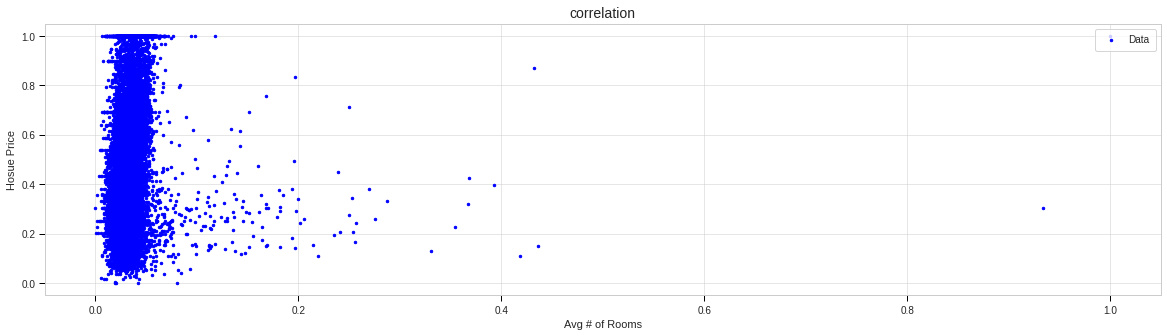

In [9]:
def drawScatterAndLines(x, y, lines=[], titles={'main':None, 'x':None, 'y':None}):
  plt.figure(figsize=(20, 5))
  plt.rcParams['figure.dpi'] = 200
  plt.style.use('seaborn-whitegrid')
  plt.scatter(x, y, label='Data', c='blue', s=6)
  for (x_line, y_line) in lines:
    plt.plot(x_line, y_line, c='red', lw=3, label='Regression')
  plt.title(titles['main'], fontSize=14)
  plt.xlabel(titles['x'], fontSize=11)
  plt.ylabel(titles['y'], fontSize=11)
  plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
  plt.tick_params(direction='out', length=6, color='black', width=1, grid_alpha=.6)
  plt.show()

drawScatterAndLines(x_rescale, y_rescale, titles={'main':'correlation', 'x':'Avg # of Rooms', 'y':'Hosue Price'})


## Toy Linear Regression 
* Use only a single feature RM to fit house price.
* This could be called Simple Linear Regression.
* Plot the regression line.


training error = 0.0553


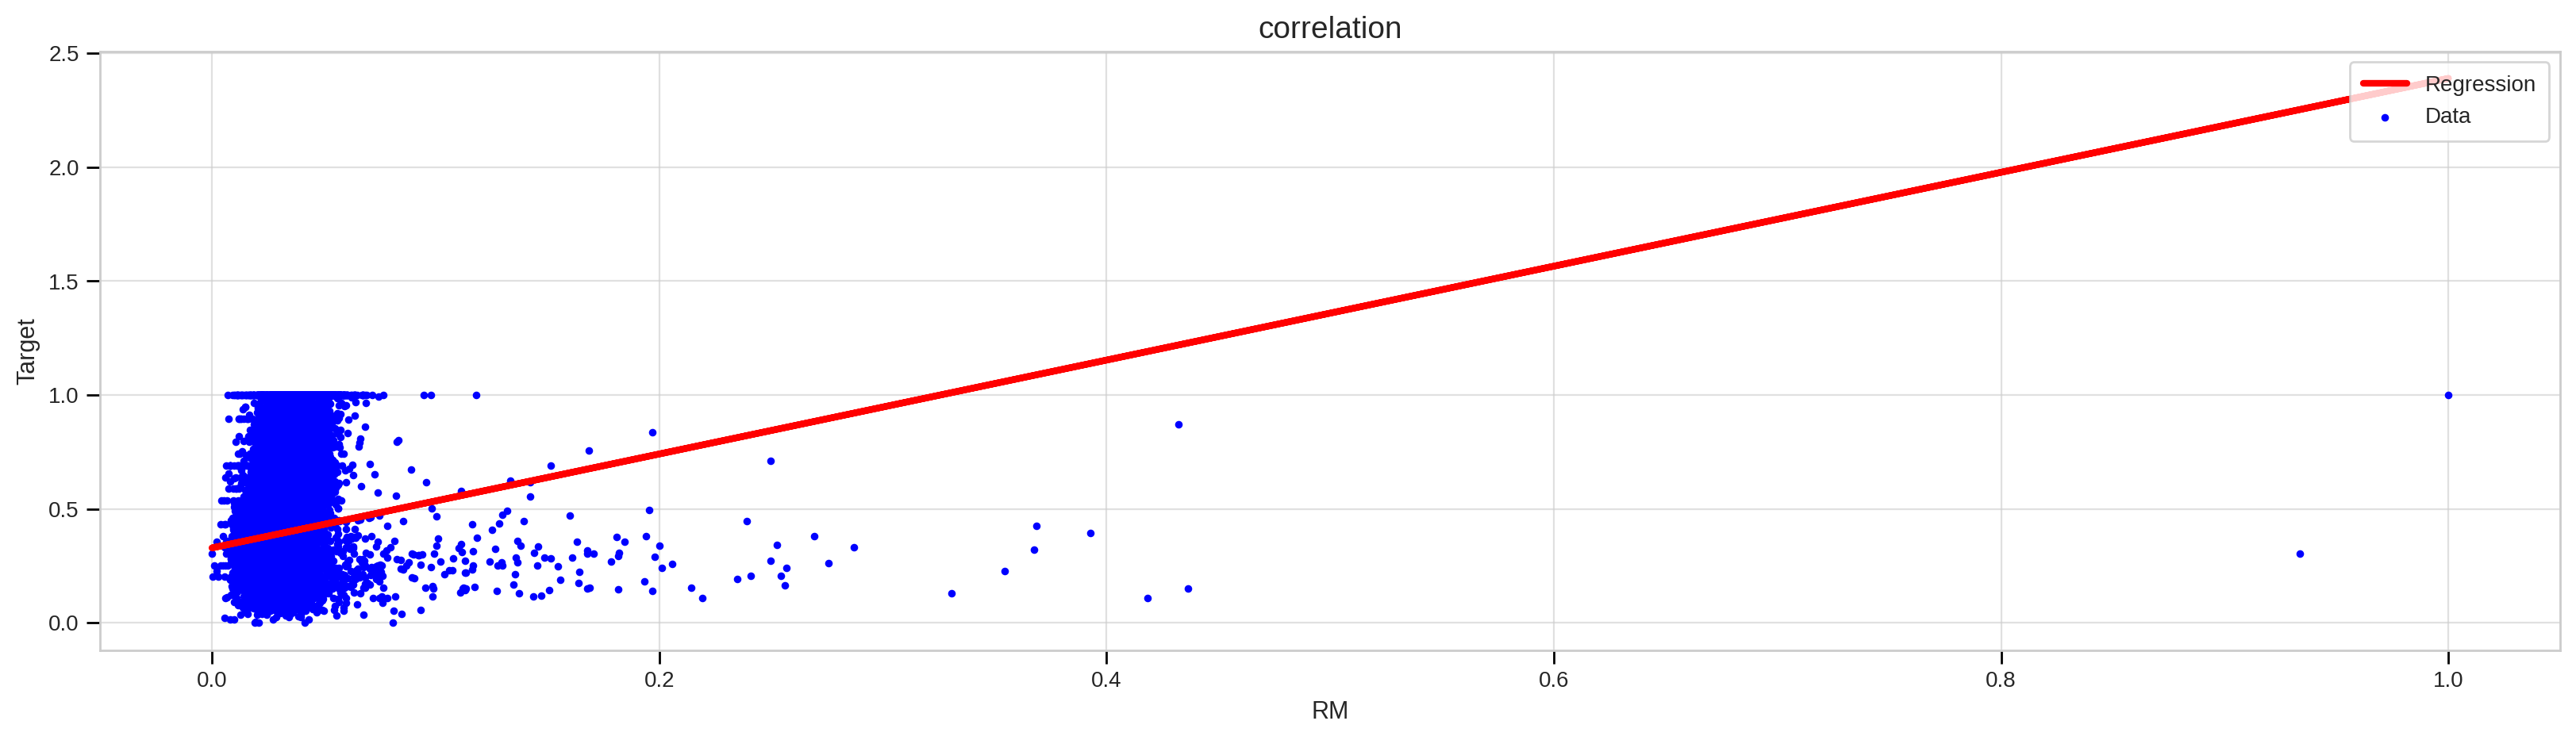

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def toyLinearRegression(df, feature_name, target_name):
  # This function performs a simple linear regression.
  # With a single feature (given by feature_name)
  # With a rescaling (for stability of test)
  x = rescaleVector(df[feature_name])
  y = rescaleVector(df[target_name])
  x_train = x.values.reshape(-1, 1)
  y_train = y.values.reshape(-1, 1)

  # Perform linear regression.
  lr = LinearRegression()
  lr.fit(x_train, y_train)
  y_train_pred = lr.predict(x_train)
  
  # Return training error and (x_train, y_train, y_train_pred)
  return mean_squared_error(y_train, y_train_pred), (x_train, y_train, y_train_pred)

ToyTrainingError, (x_rescale_train, y_rescale_train, y_rescale_train_pred) = toyLinearRegression(Df, 'AveRooms', 'Target')
print('training error = %.4f' % ToyTrainingError)
drawScatterAndLines(x_rescale_train, y_rescale_train, lines=[(x_rescale_train, y_rescale_train_pred)], titles={'main':'correlation', 'x':'RM', 'y':'Target'})


In [12]:
from sklearn.linear_model import LinearRegression
X= [[-1,1],[1,1],[3,9]]
y = [6,0,2]
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [13]:
print(f"w0: {lr.intercept_}")
print(f"w1: {lr.coef_[0]}")
print(f"w2: {lr.coef_[1]}")

w0: 1.9999999999999982
w1: -2.999999999999999
w2: 1.0000000000000002


## Main Linear Regression 
* Use all of multi-variate features to fit house price.
* This could be called Multiple Linear Regression.

In [14]:
from sklearn.model_selection import train_test_split
def splitTrainTest(df, size):
  X, y = df.drop('Target', axis=1), df.Target
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, test_size=X.shape[0] - size, random_state=0)
  return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = splitTrainTest(Df, 350)
LR = LinearRegression()
LR.fit(X_train, y_train)
print(LR.coef_)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)


[ 4.71577057e-01  1.41839235e-02 -1.14080910e-01  1.01201917e+00
  5.12834924e-05 -2.63776093e-01 -3.76277027e-01 -3.61518725e-01]


## Measure training and test accuracy
* Use Mean Squared Error.

In [15]:
from sklearn.metrics import mean_squared_error
print('Training error = %.4f' % mean_squared_error(y_train, y_train_pred))
print('Test error = %.4f' % mean_squared_error(y_test, y_test_pred))


Training error = 0.3965
Test error = 7.9480


# Programming Assignment (PA)
* Implement predict().
* Implement batchGradientDescent().
* Implement stocGradientDescent().
* Implement normalEquation().
* Play with testYourCode() that compares your implementations against scikit-learn's results. **Do not change alpha and epoch options separately provided to bgd and sgd for single-feature simple linear regression.**
* Once everything is done, then compare your implementations against scikit-learn's results using the entire features. **Now play with different alpha and epoch values, reporting your comparative impressions among bgd, sgd, and normal equations.**

In [ ]:
class MyLinearRegression:  
  theta = None

  def fit(self, X, y, option, alpha, epoch):
    X = np.concatenate((np.array(X), np.ones((X.shape[0], 1), dtype=np.float64)), axis=1)
    y = np.array(y)       
    if option.lower() in ['bgd', 'gd']:
      # Run batch gradient descent.
      self.theta = self.batchGradientDescent(X, y, alpha, epoch)      
    elif option.lower() in ['sgd']:
      # Run stochastic gradient descent.
      self.theta = self.stocGradientDescent(X, y, alpha, epoch)
    else:
      # Run solving the normal equation.      
      self.theta = self.normalEquation(X, y)
    
  def predict(self, X):
    X = np.concatenate((np.array(X), np.ones((X.shape[0], 1), dtype=np.float64)), axis=1)
    if isinstance(self.theta, np.ndarray):
      # TO-DO: ############################################# 
      
      ######################################################
      return y_pred
    return None

  def batchGradientDescent(self, X, y, alpha=0.00001, epoch=100000):
    (m, n) = X.shape      
    theta = np.zeros((n, 1), dtype=np.float64)
    for iter in range(epoch):
      if (iter % 1000) == 0:
        print('- currently at %d epoch...' % iter)    
      for j in range(n):
        # TO-DO: ############################################# 
          
        ######################################################
    return theta

  def stocGradientDescent(self, X, y, alpha=0.000001, epoch=10000):
    (m, n) = X.shape
    theta = np.zeros((n, 1), dtype=np.float64)
    for iter in range(epoch):
      if (iter % 100) == 0:
        print('- currently at %d epoch...' % iter)
      for i in range(m):
        for j in range(n):
          # TO-DO: ############################################# 
          
          ######################################################    
    return theta

  def normalEquation(self, X, y):
    # TO-DO: ############################################# 
    
    ######################################################
    return theta

  @staticmethod
  def toyLinearRegression(df, feature_name, target_name, option, alpha, epoch):
    # This function performs a simple linear regression.
    # With a single feature (given by feature_name)
    # With a rescaling (for stability of test)
    x = rescaleVector(df[feature_name])
    y = rescaleVector(df[target_name])
    x_train = x.values.reshape(-1, 1)
    y_train = y.values.reshape(-1, 1)

    # Perform linear regression.    
    lr = MyLinearRegression()
    lr.fit(x_train, y_train, option, alpha, epoch)
    y_train_pred = lr.predict(x_train)
    
    # Return training error and (x_train, y_train, y_train_pred)
    return mean_squared_error(y_train, y_train_pred), (x_train, y_train, y_train_pred)




In [ ]:
def testYourCode(df, feature_name, target_name, option, alpha, epoch):
  trainError0, (x_train0, y_train0, y_train_pred0) = toyLinearRegression(df, feature_name, target_name)
  trainError1, (x_train1, y_train1, y_train_pred1) = MyLinearRegression.toyLinearRegression(df, feature_name, target_name, option, alpha, epoch)
  drawScatterAndLines(x_train0, y_train0, lines=[(x_train0, y_train_pred0)], titles={'main':'Linear Regression', 'x':feature_name, 'y':target_name})
  drawScatterAndLines(x_train1, y_train1, lines=[(x_train1, y_train_pred1)], titles={'main':'Linear Regression', 'x':feature_name, 'y':target_name})
  return trainError0, trainError1

TrainError0, TrainError1 = testYourCode(Df, 'HouseAge', 'Target', option='sgd', alpha=0.001, epoch=500)
print("Scikit's training error = %.6f / My training error = %.6f --> Difference = %.4f" % (TrainError0, TrainError1, np.abs(TrainError0 - TrainError1)))
TrainError0, TrainError1 = testYourCode(Df, 'AveRooms', 'Target', option='bgd', alpha=0.1, epoch=5000)
print("Scikit's training error = %.6f / My training error = %.6f --> Difference = %.4f" % (TrainError0, TrainError1, np.abs(TrainError0 - TrainError1)))


In [ ]:
MyLR = MyLinearRegression()
MyLR.fit(X_train, y_train.values.reshape(-1, 1), option='sgd', alpha=0.000001, epoch=10000)
print(MyLR.theta)
y_train_pred = MyLR.predict(X_train)
y_test_pred = MyLR.predict(X_test)

print('Training error = %.4f' % mean_squared_error(y_train, y_train_pred))
print('Test error = %.4f' % mean_squared_error(y_test, y_test_pred))